In [1]:
%pip install -r requirements.txt

Note: you may need to restart the kernel to use updated packages.


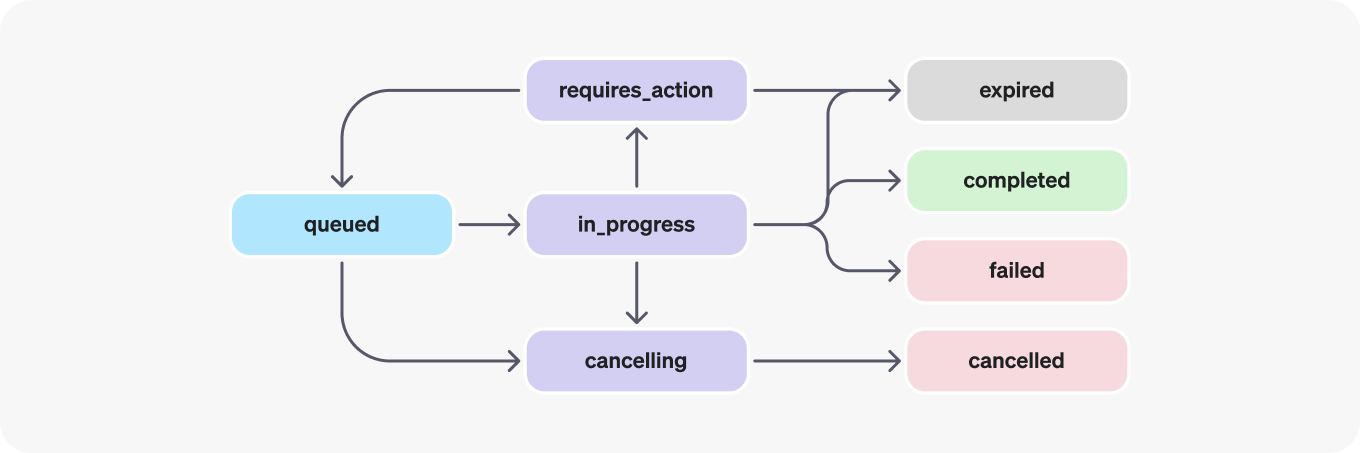

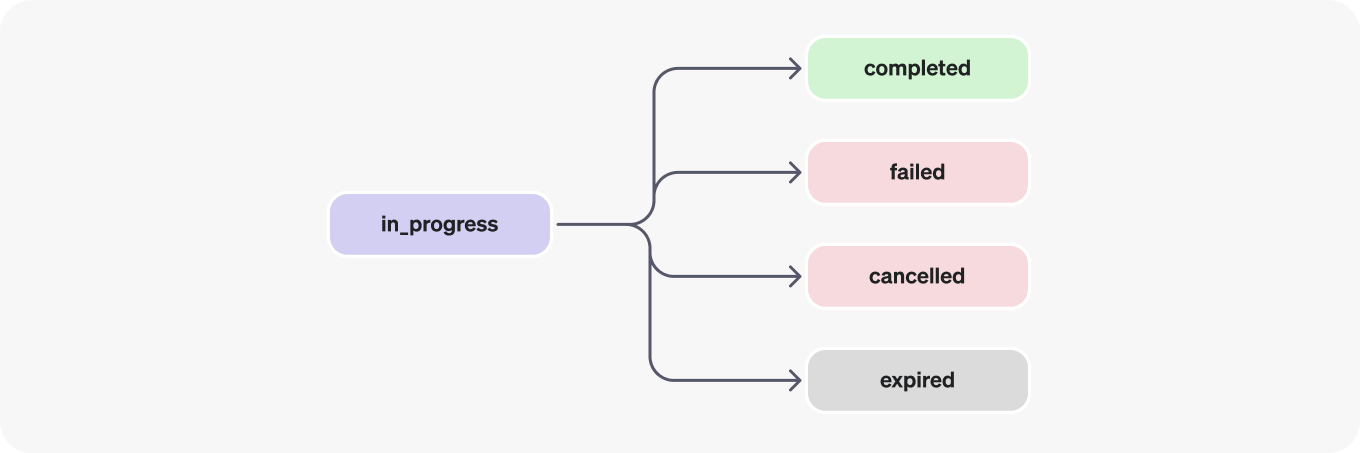

In [2]:
import os
from openai import OpenAI
from dotenv import find_dotenv, load_dotenv
from openai.types.beta import Assistant

In [3]:
import warnings

# Ignore only DeprecationWarnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [4]:
_ : bool = load_dotenv(find_dotenv()) # read local .env file

client : OpenAI = OpenAI()

In [5]:
_

True

In [6]:
# Get the key
api_key = os.getenv("OPENAI_API_KEY")

# Check and print whether it's loaded
if api_key:
    print("🔐 OpenAI Key Loaded:", bool(api_key))  # True or False
if not api_key:
    raise EnvironmentError("❌ OPENAI_API_KEY not found in .env file!")

🔐 OpenAI Key Loaded: True


In [7]:
import json

def show_json(obj):
    display(json.loads(obj.model_dump_json()))

## **Custom functions**

In [8]:
def get_current_temperature(location: str, unit: str = "Celsius") -> dict:
    # Dummy response
    temperature_data = {
        "location": location,
        "temperature": 32 if unit == "Celsius" else 89.6,
        "unit": unit,
        "description": "Sunny with mild humidity"
    }
    return temperature_data


In [9]:
def get_rain_probability(location: str) -> dict:
    # Dummy response
    rain_data = {
        "location": location,
        "rain_probability_percent": 15,
        "summary": "Low chance of rain today"
    }
    return rain_data


## **Define functions**

In [10]:
from openai import OpenAI


client = OpenAI()
 
assistant : Assistant = client.beta.assistants.create(
  instructions="You are a weather bot. Use the provided functions to answer questions.",
  name= " Weather Assistant",
  model="gpt-3.5-turbo-1106",
  tools=[
    {
      "type": "function",
      "function": {
        "name": "get_current_temperature",
        "description": "Get the current temperature for a specific location",
        "parameters": {
          "type": "object",
          "properties": {
            "location": {
              "type": "string",
              "description": "The city and state, e.g., San Francisco, CA"
            },
            "unit": {
              "type": "string",
              "enum": ["Celsius", "Fahrenheit"],
              "description": "The temperature unit to use. Infer this from the user's location."
            }
          },
          "required": ["location", "unit"]
        }
      }
    },
    {
      "type": "function",
      "function": {
        "name": "get_rain_probability",
        "description": "Get the probability of rain for a specific location",
        "parameters": {
          "type": "object",
          "properties": {
            "location": {
              "type": "string",
              "description": "The city and state, e.g., San Francisco, CA"
            }
          },
          "required": ["location"]
        }
      }
    }
  ]
)

## **Create a Thread and add Messages**

In [11]:
from openai.types.beta.thread import Thread

thread : Thread = client.beta.threads.create()
message = client.beta.threads.messages.create(
  thread_id=thread.id,
  role="user",
  content="What's the weather in San Francisco today and the likelihood it'll rain?",
)

## **Initiate a Run**

In [12]:
from typing_extensions import override
from openai import AssistantEventHandler
import json
 
# Define custom event handler
class EventHandler(AssistantEventHandler):
    @override
    def on_event(self, event):
        if event.event == 'thread.run.requires_action':
            run_id = event.data.id
            self.handle_requires_action(event.data, run_id)

    def handle_requires_action(self, data, run_id):
        tool_outputs = []

        for tool in data.required_action.submit_tool_outputs.tool_calls:
            name = tool.function.name
            args = json.loads(tool.function.arguments)

            if name == "get_current_temperature":
                result = get_current_temperature(**args)
                tool_outputs.append({"tool_call_id": tool.id, "output": json.dumps(result)})

            elif name == "get_rain_probability":
                result = get_rain_probability(**args)
                tool_outputs.append({"tool_call_id": tool.id, "output": json.dumps(result)})

        self.submit_tool_outputs(tool_outputs, run_id)

    def submit_tool_outputs(self, tool_outputs, run_id):
        with client.beta.threads.runs.submit_tool_outputs_stream(
            thread_id=self.current_run.thread_id,
            run_id=self.current_run.id,
            tool_outputs=tool_outputs,
            event_handler=EventHandler(),
        ) as stream:
            for text in stream.text_deltas:
                print(text, end="", flush=True)
            print()

# Start the assistant run with streaming and handle function calls
with client.beta.threads.runs.stream(
    thread_id=thread.id,
    assistant_id=assistant.id,
    event_handler=EventHandler()
) as stream:
    stream.until_done()

The current temperature in San Francisco is 32°C and it's sunny with mild humidity. There's a 15% chance of rain today.


In [13]:
dir(stream)

['_AssistantEventHandler__current_message_snapshot',
 '_AssistantEventHandler__current_run',
 '_AssistantEventHandler__current_run_step_id',
 '_AssistantEventHandler__message_snapshots',
 '_AssistantEventHandler__run_step_snapshots',
 '_AssistantEventHandler__stream',
 '__annotations__',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__iter__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__next__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__stream__',
 '__subclasshook__',
 '__text_deltas__',
 '__weakref__',
 '_current_event',
 '_current_message_content',
 '_current_message_content_index',
 '_current_tool_call',
 '_current_tool_call_index',
 '_emit_sse_event',
 '_init',
 '_iterator',
 'close',
 'current_event',
 'current_message_snapshot',
 'current_run',
 'current_r

## **2nd Example**

In [14]:
# Example dummy function hard coded to return the same weather
# In production, this could be your backend API or an external API
def getCurrentWeather(location:str, unit:str="fahrenheit")->str | dict | None:
    """Get the current weather in a given location"""
    if "tokyo" in location.lower():
        return json.dumps({"location": "Tokyo", "temperature": "10", "unit": "celsius"})
    elif "los angeles" in location.lower():
        return json.dumps({"location": "San Francisco", "temperature": "72", "unit": "fahrenheit"})
    elif "paris" in location.lower():
        return json.dumps({"location": "Paris", "temperature": "22", "unit": "celsius"})
    else:
        return json.dumps({"location": location, "temperature": "unknown"})
    

def getNickname(location:str)->str:
    """Get the nickname of a city"""
    if "tokyo" in location.lower():
        return "tk"
    elif "los angeles" in location.lower():
        return "la"
    elif "paris" in location.lower():
        return "py"
    else:
        return location

In [15]:
import json

def show_json(message, obj):
    display(message, json.loads(obj.model_dump_json()))

In [16]:
from openai.types.beta import Assistant

assistant: Assistant = client.beta.assistants.create(
    name= "Weather Assistant",
  instructions="You are a weather bot. Use the provided functions to answer questions.",
  model="gpt-3.5-turbo-1106",
  tools=[{
      "type": "function",
    "function": {
      "name": "getCurrentWeather",
      "description": "Get the weather in location",
      "parameters": {
        "type": "object",
        "properties": {
          "location": {"type": "string", "description": "The city and state e.g. San Francisco, CA"},
          "unit": {"type": "string", "enum": ["c", "f"]}
        },
        "required": ["location"]
      }
    }
  }, {
    "type": "function",
    "function": {
      "name": "getNickname",
      "description": "Get the nickname of a city",
      "parameters": {
        "type": "object",
        "properties": {
          "location": {"type": "string", "description": "The city and state e.g. San Francisco, CA"},
        },
        "required": ["location"]
      }
    } 
  }]
)

In [17]:
from openai.types.beta.thread import Thread

thread: Thread  = client.beta.threads.create()

print(thread)

Thread(id='thread_d7MjpHGb6ZXCADpuuBSIxUrE', created_at=1753092985, metadata={}, object='thread', tool_resources=ToolResources(code_interpreter=None, file_search=None))


In [18]:
from openai.types.beta.threads import Message

# First Request
message : Message = client.beta.threads.messages.create(
    thread_id=thread.id,
    role="user",
    content="How is the weather in Los Angles?"
)

In [19]:
dict(message)

{'id': 'msg_oR0Zn2uAT0tq3ZE80q9iuv55',
 'assistant_id': None,
 'attachments': [],
 'completed_at': None,
 'content': [TextContentBlock(text=Text(annotations=[], value='How is the weather in Los Angles?'), type='text')],
 'created_at': 1753092986,
 'incomplete_at': None,
 'incomplete_details': None,
 'metadata': {},
 'object': 'thread.message',
 'role': 'user',
 'run_id': None,
 'status': None,
 'thread_id': 'thread_d7MjpHGb6ZXCADpuuBSIxUrE'}

In [20]:
from openai.types.beta.threads.run import Run

run: Run = client.beta.threads.runs.create(
  thread_id=thread.id,
  assistant_id=assistant.id
)

In [21]:
dict(run)

{'id': 'run_n9D9BBOMAOGMILenT4pYXIjt',
 'assistant_id': 'asst_9P3P44mRbHlgjpaRp7kgJNFY',
 'cancelled_at': None,
 'completed_at': None,
 'created_at': 1753092986,
 'expires_at': 1753093586,
 'failed_at': None,
 'incomplete_details': None,
 'instructions': 'You are a weather bot. Use the provided functions to answer questions.',
 'last_error': None,
 'max_completion_tokens': None,
 'max_prompt_tokens': None,
 'metadata': {},
 'model': 'gpt-3.5-turbo-1106',
 'object': 'thread.run',
 'parallel_tool_calls': True,
 'required_action': None,
 'response_format': 'auto',
 'started_at': None,
 'status': 'queued',
 'thread_id': 'thread_d7MjpHGb6ZXCADpuuBSIxUrE',
 'tool_choice': 'auto',
 'tools': [FunctionTool(function=FunctionDefinition(name='getCurrentWeather', description='Get the weather in location', parameters={'type': 'object', 'properties': {'location': {'type': 'string', 'description': 'The city and state e.g. San Francisco, CA'}, 'unit': {'type': 'string', 'enum': ['c', 'f']}}, 'required'

In [22]:
available_functions = {
    "getCurrentWeather": getCurrentWeather,
    "getNickname": getNickname
} 

In [23]:
thread.id

'thread_d7MjpHGb6ZXCADpuuBSIxUrE'

In [24]:
import time

  # Loop until the run completes or requires action
while True:
    runStatus = client.beta.threads.runs.retrieve(thread_id=thread.id,
                                                  run_id=run.id)
    # Add run steps retrieval here for debuging
    run_steps = client.beta.threads.runs.steps.list(thread_id=thread.id, run_id=run.id)
    # show_json("Run Steps:", run_steps)
    print(runStatus.status ,'.....')

    # This means run is making a function call   
    if runStatus.status == "requires_action":
        print(runStatus.status ,'.....')
        print("Status: ", "requires_action")
        show_json("submit_tool_outputs", runStatus.required_action)
        if runStatus.required_action.submit_tool_outputs and runStatus.required_action.submit_tool_outputs.tool_calls:
            print("toolCalls present:")
            toolCalls = runStatus.required_action.submit_tool_outputs.tool_calls

            tool_outputs = []
            for toolcall in toolCalls:
                function_name = toolcall.function.name
                function_args = json.loads(toolcall.function.arguments)
                
                if function_name in available_functions:
                    
                    
                    function_to_call = available_functions[function_name]
                    print(function_to_call,function_to_call.__name__=="getCurrentWeather","================================================================")
                  
                    if function_to_call.__name__ == "getCurrentWeather":
                        
                        response = function_to_call(
                        location=function_args.get("location"),
                        unit=function_args.get("unit")
                        )
                        
                        
                        tool_outputs.append({
                                  "tool_call_id": toolcall.id,
                                  "output": response
                              })
                    
                    elif function_to_call.__name__ == "getNickname":
                        response = function_to_call(
                          location=function_args.get("location")
                          )
                        tool_outputs.append({
                          "tool_call_id": toolcall.id,
                          "output": response,
                              })
            print(tool_outputs,">>>>>") 
            # Submit tool outputs and update the run
            client.beta.threads.runs.submit_tool_outputs(
                thread_id=thread.id,
                run_id=run.id,
                tool_outputs=tool_outputs)
      
    elif runStatus.status == "completed":
        # List the messages to get the response
        print("completed...........logic")
        messages: list[Message] = client.beta.threads.messages.list(thread_id=thread.id)
        for message in messages.data:
            role_label = "User" if message.role == "user" else "Assistant"
            message_content = message.content[0].text.value
            print(f"{role_label}: {message_content}\n")
        break  # Exit the loop after processing the completed run

    elif run.status == "failed":
      print("Run failed.")
      break

    elif run.status in ["in_progress", "queued"]:
      print(f"Run is {run.status}. Waiting...")
      time.sleep(5)  # Wait for 5 seconds before checking again

    else:
      print(f"Unexpected status: {run.status}")
      break

queued .....
Run is queued. Waiting...
requires_action .....
requires_action .....
Status:  requires_action


'submit_tool_outputs'

{'submit_tool_outputs': {'tool_calls': [{'id': 'call_rpHW2eGuseK9wo5hzrHVZua8',
    'function': {'arguments': '{"location": "Los Angeles, CA", "unit": "c"}',
     'name': 'getCurrentWeather'},
    'type': 'function'},
   {'id': 'call_oCem0LKuNAtbXYolmXJ5xSIA',
    'function': {'arguments': '{"location": "Los Angeles, CA"}',
     'name': 'getNickname'},
    'type': 'function'}]},
 'type': 'submit_tool_outputs'}

toolCalls present:
<function getCurrentWeather at 0x0000013843979DA0> True ================================================================
<function getNickname at 0x0000013843979E40> False ================================================================
[{'tool_call_id': 'call_rpHW2eGuseK9wo5hzrHVZua8', 'output': '{"location": "San Francisco", "temperature": "72", "unit": "fahrenheit"}'}, {'tool_call_id': 'call_oCem0LKuNAtbXYolmXJ5xSIA', 'output': 'la'}] >>>>>
in_progress .....
Run is queued. Waiting...
completed .....
completed...........logic
Assistant: The current weather in Los Angeles is 72°F. Los Angeles is also known as "LA".

User: How is the weather in Los Angles?

